In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## matplotlib技巧集

介紹一些比較特殊的用法。

In [1]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

plt.rcParams["font.family"] = "simsun" # 可以直接修改設定字典，設定預設字型，這樣就不需要在每次繪製文字時設定字型了
plt.rcParams['axes.unicode_minus']=False    # 當座標軸上的 負號無法正常顯示時，需加這行 code

### 使用agg背景在圖形上繪圖

matplotlib 繪製的圖表十分細膩，這是因為它的後台繪圖函數庫是用 C++ 開發的高品質反鋸齒二維繪圖函數庫：Anti-Grain Geometry(AGG)。如果想繪製一些二維圖形，但不需要 matplotlib 的圖表功能，我們可以直接在記憶體中繪製影像，然後將其轉換成 numpy 陣列。

下面的程式載入 `RendererAgg`(畫布)，並建立一個長寬都是 250 個像素的 `RendererAgg` 物件，其第三個參數為 `DPI` ，該參數不影響畫布的大小。其 `buffer_rgba()` 方法獲得畫布中儲存繪圖結果的快取，透過 `frombuffer()` 將該快取轉為 numpy 陣列，並按照畫布的大小呼叫 `reshape()` 。最後獲得的陣列 arr 的形狀為 (250, 250, 4) ，其中第 2 軸的 4 表示畫布有 4 個通道：紅、綠、藍、透明。

In [2]:
import numpy as np
from matplotlib.backends.backend_agg import RendererAgg

w, h = 250, 250
renderer = RendererAgg(w, h, 90)
buf = renderer.buffer_rgba()
arr = np.frombuffer(buf, np.uint8).reshape(h, w, -1)
print(arr.shape)

(250, 250, 4)


`RendererAgg` 物件提供了一些 `draw_*()` 方法用於在畫布上繪圖，例如下面的程式首先建立一個 `Path` 物件，然後呼叫 `renderer.draw_path()` 在畫布上繪製該 `Path` 物件，如圖 4-41 所示。其第一個參數為一個 `GraphicsContextBase` 物件，用來設定繪圖時的一些屬性，例如線寬、線條顏色等。第三個參數是一個座標轉換物件，在本例中使用恆等轉換，第 4 個參數為路徑的填充顏色。

In [3]:
from matplotlib.path import Path
from matplotlib import transforms

path_data = [
    (Path.MOVETO, (179, 1)),
    (Path.CURVE4, (117, 75)),
    (Path.CURVE4, (12, 230)),
    (Path.CURVE4, (118, 230)),
    (Path.LINETO, (142, 187)),
    (Path.CURVE4, (210, 290)),
    (Path.CURVE4, (250, 132)),
    (Path.CURVE4, (200, 105)),
    (Path.CLOSEPOLY, (179, 1)),
]

code, points = zip(*path_data)
path = Path(points, code)

gc = renderer.new_gc()
gc.set_linewidth(2)
gc.set_foreground((1, 0, 0))
gc.set_antialiased(True)
renderer.draw_path(gc, path, transforms.IdentityTransform(), (0, 1, 0))

也可以使用 matplotlib 中提供的 `Artist` 物件繪圖。下面首先建立一個 `Circle` 物件和一個 `Text` 物件，然後呼叫它們的 `draw()` 方法在畫布上繪圖。由於 `Text` 物件在繪圖時需要取得畫布的 `dpi` 屬性，因此在呼叫 `draw()` 之前先將其 `figure` 屬性設定為 `renderer`。

In [4]:
from matplotlib.patches import Circle
from matplotlib.text import Text

c = Circle((w/2, h/2), 50, edgecolor="blue", facecolor="yellow", linewidth=2, alpha=0.5)
c.draw(renderer)

text = Text(w/2, h/2, "Circle", va="center", ha="center")
text.figure = renderer
text.draw(renderer)

為了在 IPython Notebook 中顯示 arr 所表示的影像，可以呼叫 `pypolt.imsave()`。其第一個參數可以是檔案名稱或擁有檔案介面的物件，這裡使用 `BytesIO` 物件將 PNG 影像的內容儲存在 png_buf 中。然後使用 IPython 的 `display_png()` 顯示該記憶體中的 PNG 影像。

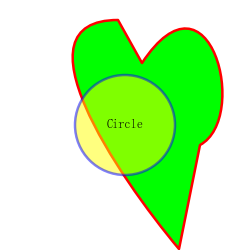

In [5]:
#%fig=直接使用RendererAgg繪圖
from io import BytesIO
from IPython.display import display_png
png_buf = BytesIO()
plt.imsave(png_buf, arr, format="png")
display_png(png_buf.getvalue(), raw=True)

可以在影像上繪圖的 `ImageDrawer` 類別。下面使用 `ImageDrawer` 在影像上繪製標、文字、直線、圓形、矩形以及橢圓，並使用 `%array_image` 魔法指令將結果影像顯示在 Notebook 中，結果如圖4-42所示。

`ImageDrawer` 的 `reverse` 參數決定 Y 軸的方向，預設值為 True，表示 Y 軸方向向下，和影像的像素座標系方向相同，False 表示 Y 軸方向向上，和數學上的笛卡爾座標系的定義相同。

> **SOURCE**

> `scpy2.matplotlib.ImageDrawer`：使用`RendererAgg`直接在圖形上繪圖，方便使用者在圖形上標注訊息。

In [6]:
# #%fig=使用本書提供的ImageDrawer在圖形上繪圖
import os
import sys 
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../codes/")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../codes/scpy2/")))
from scpy2.matplotlib import ImageDrawer
img = plt.imread("vinci_target.png")
drawer = ImageDrawer(img)
drawer.set_parameters(lw=2, color="white", alpha=0.5)
drawer.line(8, 60, 280, 60)
drawer.circle(123, 130, 50, facecolor="yellow", lw=4)
drawer.markers("x", [82, 182], [218, 218], [50, 100])
drawer.rectangle(81, 330, 100, 30, facecolor="blue")
drawer.text(10, 50, u"Mona Lisa", fontsize=40)
drawer.ellipse(119, 255, 200, 100, 100, facecolor="red")
# %array_image drawer.to_array()

### 響應滑鼠與鍵碟事件

> **TIP**

> 為了在Notebook中執行本節程式碼，需要啟動GUI事件處理執行緒，例如執行`%gui qt`和`%matplotlib qt`，將啟動Qt的GUI執行緒，並將`Qt4Agg`設定為matplotlib的繪圖背景。若果希望切換到內嵌模式，可以再執行`%matplotlib inline`。

介面中的事件綁定都是透過 `Figure.canvas.mpl_connect()` 進行的，它的第一個參數為事件名，第二個參數為事件回應函數，當指定的事件發生時，將呼叫指定的函數。

In [8]:
%gui qt
%matplotlib qt

ImportError: Failed to import any qt binding

#### 鍵盤事件

下面的程式回應鍵盤按鍵，並輸出按鍵的值：

> **SOURCE**

> `scpy2.matplotlib.key_event_show_key`：顯示觸發鍵碟按鍵事件的按鍵名稱。

In [28]:
#%hide
# %exec_python -m scpy2.matplotlib.key_event_show_key

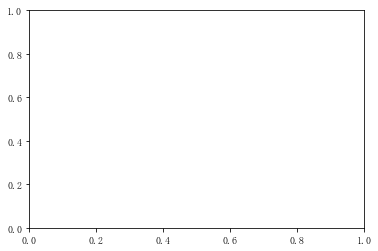

In [7]:
import sys

fig, ax = plt.subplots()

def on_key_press(event):
    print(event.key)
    sys.stdout.flush()
    
fig.canvas.mpl_connect('key_press_event', on_key_press);

可以透過 `mpl_connect` 的說明文件檢視所有的事件名稱。表4-8列出了其支援的所有事件名：

表4-8 支援的事件名及含義
|事件名 |含義 |
|-------|-----|
|button_press_event |按下滑鼠按鍵 |
|button_release_event |釋放滑鼠按鍵 |
|draw_event |介面重新繪製 |
|key_press_event |按下鍵盤上的按鍵 |
|key_release_event |釋放鍵盤按鍵 |
|motion_notify_event |滑鼠移動 |
|pick_event |滑鼠點選繪圖物 |
|scroll_event |滑鼠滾軸事件 |
|figure_enter_event |滑鼠移進圖表 |
|figure_leave_event |滑鼠移出圖表 |
|axes_enter_event |滑鼠移進子圖 |
|axes_leave_event |滑鼠移出子圖 |
|close_event |關閉圖表 |

目前所有註冊的回應函數可以透過 `Figure.canvas.callbacks.callbacks` 檢視。下面的程式輸出所有的事件回應函數，回應函數的執行按照顯示的順序進行，可以看出除了我們綁定的回應函數之外，matplotlib 還綁定了處理快速鍵的鍵盤回應函數。

In [8]:
for key, funcs in fig.canvas.callbacks.callbacks.items():
    print(key)
    for cid, wrap in sorted(funcs.items()):
        # func = wrap.func
        # print("    {0}:{1}.{2}".format(cid, func.__module__, func))
        print("    {0}:{1}".format(cid, dir(wrap)))

button_press_event
    0:['__call__', '__callback__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_alive', '_func_ref', '_meth_type']
    3:['__call__', '__callback__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_alive', '_func_ref', '_meth_type']
scroll_event
    1:['__call__', '__callback__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute

下面的程式透過鍵盤修改曲線的顏色。由於某些按鍵與預設的快速鍵重複，因此這裡透過 `mpl.disconnect()` 取消預設快速鍵的回應函數的綁定，其參數為呼叫 `mpl_connect()` 時所傳回的整數。預設快速鍵的回應函數對應的整數可以透過 `Figure.canvas.manager.key_press_handler_id` 獲得。
- ❶ 在回應函數中透過 `line.set_color()` 修改曲線的顏色。
- ❷ 並呼叫 `Figure.canvas.draw_idle()` 重新繪製整個圖表。

> **SOURCE**

> `scpy2.matplotlib.key_event_change_color`：透過按鍵修改曲線的彩色。

In [9]:
#%hide
%exec_python -m scpy2.matplotlib.key_event_change_color

UsageError: Line magic function `%exec_python` not found.


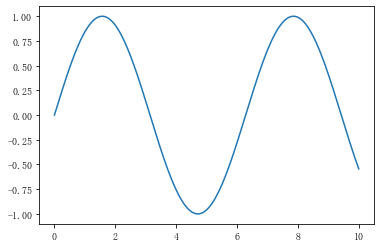

In [10]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 1000)
line, = ax.plot(x, np.sin(x))

def on_key_press(event):
    if event.key in 'rgbcmyk':
        line.set_color(event.key)  #❶
    fig.canvas.draw_idle()         #❷

fig.canvas.mpl_disconnect(fig.canvas.manager.key_press_handler_id)
fig.canvas.mpl_connect('key_press_event', on_key_press);

#### 滑鼠事件

當滑鼠在子圖範圍內產生動作時，將觸發滑鼠事件。滑鼠事件分為三種：
- `button_press_event`：滑鼠按鍵按下時觸發。
- `button_release_event`：滑鼠按鍵釋放時觸發。
- `motion_notify_event`：滑鼠移動時觸發。

滑鼠事件的相關資訊可以透過 `event` 物件的屬性獲得：
- `name`：事件名。
- `button`：滑鼠按鍵，1, 2, 3 表示左中右按鍵，None表示無按鍵。
- `x`, `y`：滑鼠在圖表中的像素座標。
- `xdata`, `ydata`：滑鼠在資料座標系中的座標。

下面的程式顯示了滑鼠事件的各種資訊：

> **SOURCE**

> `scpy2.matplotlib.mouse_event_show_info`：顯示子圖中的滑鼠事件的各種訊息。

In [11]:
#%hide
%exec_python -m scpy2.matplotlib.mouse_event_show_info

UsageError: Line magic function `%exec_python` not found.


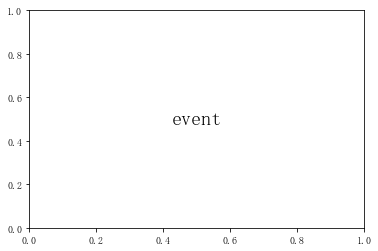

In [12]:
import sys
fig, ax = plt.subplots()
text = ax.text(0.5, 0.5, "event", ha="center", va="center", fontdict={"size":20})

def on_mouse(event):
    global e
    e = event
    info = "{}\nButton:{}\nFig x,y:{}, {}\nData x,y:{:3.2f}, {:3.2f}".format(
    event.name, event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(info)
    fig.canvas.draw()

fig.canvas.mpl_connect('button_press_event', on_mouse)
fig.canvas.mpl_connect('button_release_event', on_mouse)
fig.canvas.mpl_connect('motion_notify_event', on_mouse);

下面的實例透過回應上述三個滑鼠事件，實現圖表中形狀的移動。我們將所有的事件回應封裝到 `PatchMover` 類別中，它有三個內部使用的屬性：
- `selected_path`：儲存目前被選取的 `Patch` 物件。
- `start_mouse_pos`：儲存 `Patch` 物件被選取時滑鼠在子圖中的座標。
- `start_patch_pos`：儲存 `Pach` 物件被選取時在子圖中的座標。

- ❶ 在 `on_press()` 中，對子圖中的所有 `Patch` 物件進行循環判斷，這裡採用 `zorder` 屬性排序之後的反向循環，保障在最上層的`Patch`物件優先被選取。
- ❷ 透過 `Patch.contains_point()` 判斷目前的滑鼠座標是否在`Patch`物件之內，注意這裡需要使用圖表座標系中的像素座標。一旦判斷滑鼠在目前的`Patch`物件之中，則儲存目前`Patch`物件，以及相關的座標資訊。注意我們儲存資料座標系的座標，因為`Patch`物件的移動是在資料座標系中進行的。
- ❸ 在 `on_motion()` 中，透過目前的滑鼠座標計算被選取`Patch`物件的目前位置，所有的計算都在資料座標系中進行。
- ❹ 呼叫 `Figure.canvas.draw_idle()` 重新繪製整個圖表。
- ❺ 在 `on_release()` 中，取消被選取的 `Patch` 物件。

> **SOURCE**

> `scpy2.matplotlib.mouse_event_move_polygon`：示範透過滑鼠搬移`Patch`物件。

In [13]:
#%hide
# %exec_python -m scpy2.matplotlib.mouse_event_move_polygon

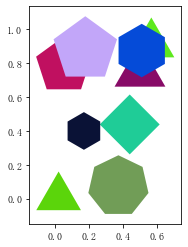

In [14]:
from numpy.random import rand, randint
from matplotlib.patches import RegularPolygon


class PatchMover(object):
    def __init__(self, ax):
        self.ax = ax
        self.selected_patch = None
        self.start_mouse_pos = None
        self.start_patch_pos = None

        fig = ax.figure
        fig.canvas.mpl_connect('button_press_event', self.on_press)
        fig.canvas.mpl_connect('button_release_event', self.on_release)
        fig.canvas.mpl_connect('motion_notify_event', self.on_motion)

    def on_press(self, event): #❶
        patches = self.ax.patches[:]
        patches.sort(key=lambda patch:patch.get_zorder())
        for patch in reversed(patches):
            if patch.contains_point((event.x, event.y)):  #❷
                self.selected_patch = patch
                self.start_mouse_pos = np.array([event.xdata, event.ydata])
                self.start_patch_pos = patch.xy
                break

    def on_motion(self, event):   #❸
        if self.selected_patch is not None:
            pos = np.array([event.xdata, event.ydata])
            self.selected_patch.xy = self.start_patch_pos + pos - self.start_mouse_pos
            self.ax.figure.canvas.draw_idle()   #❹

    def on_release(self, event):   #❺
        self.selected_patch = None

        
fig, ax = plt.subplots()
ax.set_aspect("equal")
for i in range(10):
    poly = RegularPolygon(rand(2), randint(3, 10), rand() * 0.1 + 0.1, facecolor=rand(3),
                          zorder=randint(10, 100))
    ax.add_patch(poly)
ax.relim()
ax.autoscale()
pm = PatchMover(ax)

plt.show()

#### 點選事件

上面透過 `Patch.contains_point()` 判斷滑鼠的點擊事件是否發生在`Patch` 物件內部。但是對於曲線這樣的物件，沒有類似的判斷方法。為了回應滑鼠點選圖形的事件，可以設定圖形物件的`picker`屬性為True，然後在 'pick_event'事件回應函數中加以處理。

在下面的實例中，建立了一個 `Rectangle`物件和一個`Line2D`物件，並分別設定其`picker`屬性，表示這兩個圖形物件支援點選事件。由於`Rectangle`佔據一塊面積，因此只需要設定為True即可；而對於表示曲線的 `Line2D` 物件，為了方便點選，在呼叫 `plot()` 建立曲線時透過 `picker` 參數設定了一個容錯值，滑鼠座標到曲線的距離小於 8.0 就認為該曲線被點選。

在點選事件處理函數 `on_pick()` 中，我們修改曲線的線寬和矩形的填充顏色。

> **SOURCE**

> `scpy2.matplotlib.pick_event_demo`：示範繪圖物件的點選事件。

In [15]:
#%hide
%exec_python -m scpy2.matplotlib.pick_event_demo

UsageError: Line magic function `%exec_python` not found.


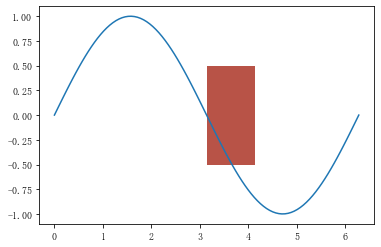

In [16]:
fig, ax = plt.subplots()
rect = plt.Rectangle((np.pi, -0.5), 1, 1, fc=np.random.random(3), picker=True)
ax.add_patch(rect)
x = np.linspace(0, np.pi*2, 100)
y = np.sin(x)
line, = plt.plot(x, y)#, picker=8.0)
line.set_pickradius(8.0)

def on_pick(event):
    artist = event.artist
    if isinstance(artist, plt.Line2D):
        lw = artist.get_linewidth()
        artist.set_linewidth(lw % 5 + 1)
    else:
        artist.set_fc(np.random.random(3))
    fig.canvas.draw_idle()
    
fig.canvas.mpl_connect('pick_event', on_pick);

#### 實時反白顯示曲線

為了方便使用者分辨多條曲線，可以透過回應滑鼠事件，當滑鼠接近某條曲線時，反白顯示該曲線。下面的實例中，我們採用物件導向的設計模式，將滑鼠事件處理函數包裝在 `CurveHighLighter`內部。它的 `alpha`參數為非反白顯示時曲線的透明度，`alpha`為1表示完全不透明，0表示完全透明；`linewidth`參數為反白顯示曲線時曲線的寬度。

- ❶ 綁定滑鼠移動事件 `motion_notify_event` 到 `on_move()` 方法之上。當滑鼠在圖表中移動時將呼叫 `on_move()`方法。
- ❷ 所有反白顯示的邏輯判斷都在 `highlight()` 中進行，其參數 `target` 為反白顯示的 `Line2D` 物件，如果為 None 表示取消反白顯示。
  - 當無反白顯示時，將所有曲線的 `alpha` 屬性和 `linewidth` 設定為 1。
  - 當有反白顯示時，將反白顯示的曲線的 `alpha` 屬性設定為1，將`linewidth`設定為3；將非反白顯示的曲線的 `alpha` 屬性設定為 0.3，將`linewidth` 設定為1。
  - 若有任意一條曲線的屬性被修改，則需要呼叫 `Figure.canvas.draw_idle()` 重新繪製整個圖表，它會等到空閒時重繪。
- ❸ 子圖中的所有曲線(`Line2D`物件)都在其屬性 `lines` 清單中，對此列表中的`Line2D`物件進行循環。`Line2D.contains()` 可以用於判斷事件是否發生在此物件內部。當滑鼠座標離曲線的像素距離小於其`pickardius`屬性時，將判斷事件發生在 `Line2D` 物件之上。`contains()` 傳回一個有兩個元素的元組，其第 0 個元素為判斷結果，第 1 個元素為儲存詳細資訊的字典。

> **SOURCE**

> `scpy2.matplotlib.mouse_event_highlight_curve`：滑鼠搬移到曲線之上時反白顯示該曲線。

In [17]:
#%hide
%exec_python -m scpy2.matplotlib.mouse_event_highlight_curve

UsageError: Line magic function `%exec_python` not found.


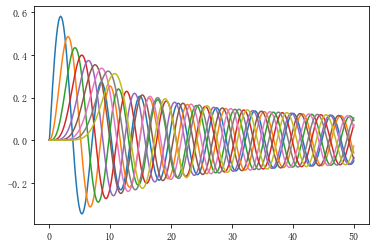

In [18]:
import matplotlib.pyplot as plt
import numpy as np

class CurveHighLighter(object):
    
    def __init__(self, ax, alpha=0.3, linewidth=3):
        self.ax = ax
        self.alpha = alpha
        self.linewidth = 3
        
        ax.figure.canvas.mpl_connect('motion_notify_event', self.on_move) #❶
        
    def highlight(self, target): #❷
        need_redraw = False
        if target is None:
            for line in self.ax.lines:
                line.set_alpha(1.0)
                if line.get_linewidth() != 1.0:
                    line.set_linewidth(1.0)
                    need_redraw = True
        else:
            for line in self.ax.lines:
                lw = self.linewidth if line is target else 1
                if line.get_linewidth() != lw:
                    line.set_linewidth(lw)
                    need_redraw = True
                alpha = 1.0 if lw == self.linewidth else self.alpha
                line.set_alpha(alpha)

        if need_redraw:
            self.ax.figure.canvas.draw_idle()
        
    def on_move(self, evt):
        ax = self.ax
        for line in ax.lines:
            if line.contains(evt)[0]: #❸
                self.highlight(line)
                break
        else:
            self.highlight(None)

fig, ax = plt.subplots()
x = np.linspace(0, 50, 300)

from scipy.special import jn

for i in range(1, 10):
    ax.plot(x, jn(i, x))

ch = CurveHighLighter(ax)

圖4-44為實際執行效果，當滑鼠移過到某條曲線之上時，該曲線粗體顯示，而其他曲線則變為半透明顯示：

### 動畫

透過修改圖形元素的各種屬性並重新繪製圖表，可以實現簡單的動畫效果。在下面的實例中：
- ❶ 首先建立一個 50 毫秒的計時器 timer，並呼叫其 `add_callback()` 增加定時事件，其第一個參數為定時事件發生時呼叫的函數，第二個參數為傳遞給此函數的物件。由於我們需要對圖表中曲線的資料進行俢改，因此需要將 `Line2D` 物件 `line` 傳遞給 `update_data()`。
- ❷ 呼叫 `Line2D.set_ydata()` 設定曲線的 Y 軸資料。
- ❸ 呼叫 `Figure.canvas.draw()` 重繪整張圖表。

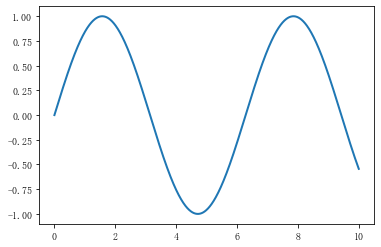

In [19]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
x = np.linspace(0, 10, 1000)
line, = ax.plot(x, np.sin(x), lw=2)

def update_data(line):
    x[:] += 0.1
    line.set_ydata(np.sin(x)) #❷
    fig.canvas.draw()         #❸

timer = fig.canvas.new_timer(interval=50) #❶
timer.add_callback(update_data, line)
timer.start()

#### 1) 使用快取快速重繪圖表

然而 `Figure.canvas.draw()` 的繪圖速度較慢，為了加強重繪速度，可以快速重繪圖表中的靜態元素，只更新了動態效果的元素。在下面的實例中：
- ❶ 建立繪畫元素時，設定其 `animated` 屬性為True。
- ❷ 在呼叫 `Figure.canvas.draw()` 重繪整個圖表時，會忽略所有 `animated` 為 True的物件。
- ❸ 這時所有的靜態元素都己經繪製完畢，呼叫 `Figure.canvas.copy_from_bbox()`儲存子圖物件對應區域中的影像資訊到 `background` 中。子圖物件在圖表物件中的位置和大小可以透過其 `bbox` 屬性獲得。

在時脈事件處理函數中，
- ❹ 首先呼叫 `Figure.canvas.restore_region()` 恢復所儲存的影像資訊，這相當於擦拭所有動態元素，重新繪製了所有的靜態元素。
- ❺ 在更新曲線的 Y 軸資料之後，呼叫子圖物件的 `draw_artist()` 在 `Canvas` 物件中繪製曲線，此時 `Canvas` 物件中己經是一幅完整的圖表影像了。
- ❻ 呼叫 `Figure.canvas.blit()` 將 `Canvas` 中指定區域的內容繪製到螢幕上。

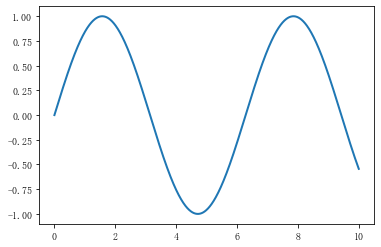

In [20]:
fig, ax = plt.subplots()
x = np.linspace(0, 10, 1000)
line, = ax.plot(x, np.sin(x), lw=2, animated=True) #❶

fig.canvas.draw() #❷
background = fig.canvas.copy_from_bbox(ax.bbox) #❸

def update_data(line):
    x[:] += 0.1
    line.set_ydata(np.sin(x)) 
    fig.canvas.restore_region(background)  #❹
    ax.draw_artist(line)     #❺
    fig.canvas.blit(ax.bbox) #❻

timer = fig.canvas.new_timer(interval=50) 
timer.add_callback(update_data, line)
timer.start()

#### 2） animation模組

透過前面兩個簡單的實例，我們了解在 matplotlib 中製作動畫的原理，不過在實際使用中，一般會使用 `animation` 模組製作動畫效果。例如 `FuncAnimation` 物件將定期呼叫使用者定義的函數來更新圖表中的元素。

- ❶ 建立曲線物件時，設定 `animated` 參數為 True。
- ❷ 在動畫回呼函數 `update_line()` 中設定所有動畫元素的資料，它有一個參數為目前的顯示頁框數，這裡使用頁框數修改波形的相位，並傳回一個包含所有動畫元素的序列。
- ❸ 建立 `FuncAnimation` 物件定時呼叫 `update_line()` ，`interval` 參數為每秒的頁框數，`blit` 為True表示使用快取加速每頁框影像的繪製。`frame`參數設定最大頁框數，`update_line()` 的頁框數參數將在 0 到 99 之間循環變化。

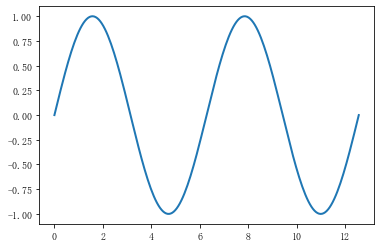

In [21]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()

x = np.linspace(0, 4*np.pi, 200)
y = np.sin(x)
line, = ax.plot(x, y, lw=2, animated=True) #❶

def update_line(i):
    y = np.sin(x + i*2*np.pi/100)
    line.set_ydata(y)
    return [line] #❷

ani = FuncAnimation(fig, update_line, blit=True, interval=25, frames=100) #❸

若想將動畫儲存成動畫檔案，可以呼叫以下方法：

> **WARNING**

> matplotlib會使用系統中安裝的視訊壓縮軟體（如`ffmpeg.exe`）產生視訊檔案。請讀者確認視訊壓縮軟體的可執行檔案的路徑是否在`PATH`環境變數中。

In [22]:
ani.save('sin_wave.mp4', fps=25)

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

### 加入GUI面板

在 matploblib 的首頁中可以找到將圖表嵌入各種主流介面函數庫的示範程式，這些程式都是首先建立一個 GUI 視窗，然後將圖表作為控制項嵌入視窗中。本節介紹一種更加簡潔的方法：為 matplotlib 圖表視窗增加 GUI 控制項的主控台。

> **SOURCE**

> `scpy2.matplotlib.gui_panel`：提供了TK與QT界面庫的滑標控制項面板類別`TkSliderPanel`和`QtSliderPanel`。`tk_panel_demo.py`和`qt_panel_demo.py`為其示範程式。

下面是使用 `TkSliderPanel` 的實例。
- ❶ 首先呼叫 `matplotlib.use()` 將後台介面函數庫設定為 "TkAgg" ，該敘述必須在 matplotlib 的其他函數之前被呼叫。
- ❷ 我們希望繪製的曲線函數由 `exp_sin()` 定義，其第一個參數為引數，其餘參數為函數中的各個係數。
- ❸ `update()` 函數接收新的係數，並呼叫 `exp_sin()` 計算新係數對應的函數值。
- ❹ 然後呼叫 `line.set_data()` 更新曲線的資料。在更新子圖的顯示範圍之後，
- ❺ 呼叫 `fig.canvas.draw_idle()` 重新繪製整個圖表。
- ❻ 建立一個 `TkSliderPanel` 物件，它的第一個參數為圖表物件，第二個參數定義主控台中的滑鼠名稱以及設定值範圍，第三個參數為回呼函數。當某個滑標控制項的值發生變化時，將呼叫此函數。
- ❼ 最後呼叫其 `set_parameters()` 設定各個滑標控制項的初值。程式的執行結果如圖4-45(左)所示，而右圖則是採用`QtSliderPanel` 時的介面畫面。
- ❽ 為了在 Notebook 中顯示 TK 介面函數庫的視窗，需要執行 `%gui tk` 魔法指令，然後呼叫 `fig.show()` 顯示圖表視窗。如果是在單獨的處理程序中執行該程式，則需要呼叫 `pl.show()` 以顯示視窗。

由於程式有關 GUI 函數庫的用法，限於篇幅這裡不再詳細斜述。

In [23]:
%gui tk
import numpy as np
import matplotlib

matplotlib.use("TkAgg")  #❶

import pylab as pl

def exp_sin(x, A, f, z, p): #❷
    return A * np.sin(2 * np.pi * f * x + p)  * np.exp(z * x)

fig, ax = pl.subplots()

x = np.linspace(1e-6, 1, 500)
pars = {"A":1.0, "f":2, "z":-0.2, "p":0}
y = exp_sin(x, **pars)

line, = pl.plot(x, y)

def update(**kw): #❸
    y = exp_sin(x, **kw)
    line.set_data(x, y) #❹
    ax.relim()
    ax.autoscale_view()
    fig.canvas.draw_idle() #❺ 

from scpy2.matplotlib.gui_panel import TkSliderPanel

panel = TkSliderPanel(fig,  #❻
                      [("A", 0, 10), ("f", 0, 10), ("z", -3, 0), ("p", 0, 2*np.pi)],
                      update, cols=2, min_value_width=80)
panel.set_parameters(**pars) #❼
fig.show() #❽

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'wx' is currently running

In [35]:
#%hide
%exec_python -m scpy2.matplotlib.tk_panel_demo

ERROR:root:Line magic function `%exec_python` not found.


In [36]:
#%hide
%exec_python -m scpy2.matplotlib.qt_panel_demo

ERROR:root:Line magic function `%exec_python` not found.
